In [79]:
import io
from pathlib import Path

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

from astropy import units as u
from astropy import table
from astropy.io import votable
from astropy.coordinates import SkyCoord

import pyvo as vo

from tqdm.notebook import tqdm

from multiprocess import Pool

from dill import dump, load

In [2]:
import warnings
from astroquery.exceptions import NoResultsWarning
warnings.simplefilter('ignore', NoResultsWarning)
warnings.simplefilter('ignore', u.UnitsWarning) # comes up in the parsing of some heasarc tables but is just a "discouraged by FITS standard" issue

In [3]:
hpath = Path('hosts.ecsv')

if hpath.exists():
    print("loading hosts from file")
    hosts = table.Table.read(hpath)
else:
    import SAGA
    saga = SAGA.QuickStart('/Users/etollerud/Dropbox/', '/../')
    hosts = saga.host_catalog.load()

loading hosts from file


In [4]:
hosts_vot = votable.from_table(hosts['HOSTID', 'RA','DEC'])
hosts_vot.get_first_table()

<VOTable length=300>
  HOSTID        RA         DEC    
  str10      float64     float64  
---------- ----------- -----------
 nsa126115    0.995382  20.7523559
   pgc1952    8.008776 -64.2533874
   pgc2052    8.564589 -27.8036183
 nsa127226    8.694936  -8.3964957
   pgc2778   11.864958 -31.4216944
   pgc3089   13.176354 -31.2058056
       ...         ...         ...
  pgc72009 354.7378755 -12.9610833
  pgc72060 354.9742875 -12.2927807
 nsa169525  356.065458  10.7670833
  pgc72444 356.9657175 -30.5220634
 nsa153017 359.8561875  20.7499195
 pgc771919   46.033425 -26.0696911
pgc3806285 200.0691045 -24.4462083

# Match using HEASARC's PyVO interface

According to Tess Jaffe, the astroquery interface is using an older not-well-supported approach, and is to be updated whenever HEASARC can get the resources to do it.

In [5]:
import pyvo

In [6]:
tap_services = pyvo.regsearch(servicetype='tap', keywords=['heasarc'])
assert len(tap_services)==1
heasarc_tap = tap_services[0]

tables_dct = dict(heasarc_tap.service.tables.items())

In [7]:
def get_matches_for_catalog(cat, radius, table, idcol='HOSTID'):
    deg = radius.to(u.deg).value
    query=f"""
    SELECT *, mt.{idcol}
    FROM {table} cat, tap_upload.mysources mt
    WHERE 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',mt.ra,mt.dec,{deg}))=1
    ORDER by cat.ra
    """
    
    vot = votable.from_table(cat[idcol, 'RA', 'DEC'])
    bio = io.BytesIO()
    vot.to_xml(bio)
    bio.seek(0)
    
    res = heasarc_tap.service.run_async(query, uploads={'mysources': bio})
    return res.to_table()

get_matches_for_catalog(hosts, 15*u.arcmin, 'chanmaster')

chanmaster___row,chanmaster_obsid,chanmaster_status,chanmaster_name,chanmaster_ra,chanmaster_dec,chanmaster_lii,chanmaster_bii,chanmaster_time,chanmaster_detector,chanmaster_grating,chanmaster_exposure,chanmaster_type,chanmaster_pi,chanmaster_cycle,chanmaster_proposal,chanmaster_public_date,chanmaster_sequence_number,chanmaster_data_mode,chanmaster_category,chanmaster_class,chanmaster___x_ra_dec,chanmaster___y_ra_dec,chanmaster___z_ra_dec,hostid
,,,,deg,deg,deg,deg,d,,,s,,,,,d,,,,,,,,
int32,int32,object,object,float64,float64,float64,float64,float64,object,object,float64,object,object,int16,object,int32,int32,object,object,int16,float64,float64,float64,object
9685,23571,archived,SN 2009em,8.68554,-8.39933,110.24683,-70.85875,59115.954849537,ACIS-S,NONE,12080,GO,Patnaude,22,22500259,59481,503246,TE_0057A,"SN, SNR AND ISOLATED NS",3200,0.149391603204477,0.977929075843426,-0.14607146029262,nsa127226
9688,27644,archived,SN 2022jli,8.69037,-8.38671,110.26870,-70.84733,59961.4469907407,ACIS-S,NONE,10060,DDT,Chen,23,23508880,59962,503448,TE_007BC,"SN, SNR AND ISOLATED NS",3200,0.149478899171775,0.977948259426569,-0.145853558705086,nsa127226
9689,27646,archived,SN 2022jli,8.69037,-8.38671,110.26870,-70.84733,59969.882962963,ACIS-S,NONE,10060,DDT,Chen,23,23508880,59970,503450,TE_007BC,"SN, SNR AND ISOLATED NS",3200,0.149478899171775,0.977948259426569,-0.145853558705086,nsa127226
9690,27645,archived,SN 2022jli,8.69037,-8.38671,110.26870,-70.84733,59965.9437962963,ACIS-S,NONE,10060,DDT,Chen,23,23508880,59969,503449,TE_007BC,"SN, SNR AND ISOLATED NS",3200,0.149478899171775,0.977948259426569,-0.145853558705086,nsa127226
5179,16352,archived,NGC289,13.17667,-31.20583,299.12257,-85.91303,56881.5004398148,ACIS-I,NONE,50090,GTO,Garmire,15,15610062,57247,601152,TE_006E6,NORMAL GALAXIES,6000,0.194972050737596,0.832792734473645,-0.518114042310268,pgc3089
13871,4408,archived,NGC 821,32.08750,10.99472,151.55478,-47.55719,52604.7187152778,ACIS-S,NONE,25270,GO,Fabbiano,4,04700486,52984,700685,TE_005A0,ACTIVE GALAXIES AND QUASARS,7000,0.521463199181968,0.831686583139149,0.190718534299197,pgc8160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6444,11344,archived,NGC7507,348.02917,-28.54061,23.44014,-68.03611,55471.1952893519,ACIS-S,NONE,7350,GO,Gallo,11,11620915,55483,600863,TE_00600,NORMAL GALAXIES,6000,-0.182208495439119,0.859374701084884,-0.477781526772518,pgc70676


In [8]:
mission_to_rad = {'xmmmaster': 15*u.arcmin, # " telescope's field of view (FOV) of 30 arcmin and in th"
                  'chanmaster':8*u.arcmin, # this is ~ half ASIC's FOV
                  'rosmaster':2.5*u.deg,  #"5 degree diameter"
                  'rassmaster':2.5*u.deg,  #"5 degree diameter"
                }

pth = Path('heasarc_master_matches.pickle')

if pth.exists():
    print(f'loading existing data from {pth}')
    with pth.open('rb') as f:
        matches = load(f)
else:
    matches = {}
    for tab in tqdm(mission_to_rad):
        matches[tab] = get_matches_for_catalog(hosts, mission_to_rad[tab], tab)
    
    print(f'writing to {pth}')
    with pth.open('wb') as f:
        dump(matches, f)
    
master_matches = matches

loading existing data from heasarc_master_matches.pickle


How many are in the footprints?

In [9]:
{k:len(v) for k,v in  master_matches.items()}

{'xmmmaster': 87, 'chanmaster': 131, 'rosmaster': 1437, 'rassmaster': 168}

And what fraction is that?

In [10]:
{k:len(v)/len(hosts) for k,v in  master_matches.items()}

{'xmmmaster': 0.29,
 'chanmaster': 0.43666666666666665,
 'rosmaster': 4.79,
 'rassmaster': 0.56}

Great!  Now lets look at mission specifc tables

# IDing specific mission tables

In [11]:
chantabs = [v.description for k,v in tables_dct.items() if 'chandra' in v.description.lower()]
len(chantabs)

188

There doesn't seem to be any way to ask TAP for just *chandra* tables. Some of the above are things that aren't quite matched. So lets instead use the astroquery interface to get those:

In [12]:
from astroquery.heasarc import Heasarc
heasarc = Heasarc()
missions = heasarc.query_mission_list()
missions['in_tap'] = [row['Table'] in tables_dct for row in missions]
missions

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
AGILE,agilecat,First AGILE Catalog of High-Confidence Gamma-Ray Sources,True
AGILE,agileupvar,Updated AGILE Catalog of Bright Gamma-Ray Sources and Variability,True
AKARI,akaribsc,"AKARI/FIS All-Sky Survey Bright Source Catalog, Version 1",True
AKARI,akaripsc,"AKARI/IRC All-Sky Survey Point Source Catalog, Version 1",True
ANS,ansuvpscat,ANS Ultraviolet Photometry Catalog of Point Sources,True
ARIEL V,ariel3a,3rd Ariel-V SSI Catalog,True
...,...,...,...
XMM-NEWTON,xmmstack,XMM-Newton Serendipitous Source Catalog from Stacked Observations (4XMM-DR13s),True
XMM-NEWTON,xmmstackob,XMM-Newton Serendipitous Source Catalog from Stacked Observations: Obs. Data,True


In [13]:
list(np.unique(missions['Mission']))

['AGILE',
 'AKARI',
 'ANS',
 'ARIEL V',
 'ASCA',
 'BBXRT',
 'BEPPOSAX',
 'CALET',
 'CGRO',
 'CHANDRA',
 'COBE',
 'COPERNICUS',
 'COROT',
 'COS B',
 'EINSTEIN',
 'EUVE',
 'EXOSAT',
 'FAUST',
 'FERMI',
 'FUSE',
 'GALAXY CATALOG',
 'GALEX',
 'GAMMA-RAY BURSTS',
 'GENERAL CATALOG',
 'GINGA',
 'GROUND-BASED',
 'HALOSAT',
 'HEAO1',
 'HERSCHEL',
 'HETE-2',
 'HITOMI',
 'HST',
 'ICECUBE',
 'INTEGRAL',
 'IRAS',
 'ISO',
 'IUE',
 'IXPE',
 'KVANT',
 'LPF',
 'MASTER CATALOG',
 'MAXI',
 'MSX',
 'NEBULA CATALOG',
 'NICER',
 'NUSTAR',
 'OSO8',
 'PLANCK',
 'RADIO CATALOG',
 'RHESSI',
 'ROSAT',
 'RXTE',
 'SAS-2',
 'SAS-3',
 'SDSS',
 'SPITZER',
 'SRG-EROSITA',
 'STAR CATALOG',
 'SUZAKU',
 'SWIFT',
 'TD1',
 'UHURU',
 'UIT',
 'VELA 5B',
 'VERITAS',
 'WISE',
 'WMAP',
 'XMM-NEWTON']

In [14]:
np.sum(missions['in_tap']), len(missions)

(1184, 1185)

In [15]:
missions[~missions['in_tap']]

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
RADIO CATALOG,first,Faint Images of the Radio Sky at Twenty cm (FIRST),False


Weird!  But ok that means we are fine for the others

188 < 200 , so some are missing from the list above proving the problem.

# Download all the source matches

Chandra has *arcsec* resolution, but I'm not confident I understand enough about extended source catalogs to know how to interpret that for something as sensitive as Chandra.  So we'll just choose 2 arcmin as a not-crazy scale to be conservative about

In [16]:
chandra_tables = missions[(missions['Mission']=='CHANDRA') & (np.char.count(missions['Table'], 'master')==0)]
chandra_tables

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
CHANDRA,acceptcat,Archive of Chandra Cluster Entropy Profile Tables (ACCEPT) Catalog,True
CHANDRA,aegisx,AEGIS-X Chandra Extended Groth Strip X-Ray Point Source Catalog,True
CHANDRA,aegisxdcxo,AEGIS-X Deep Survey Chandra X-Ray Point Source Catalog,True
CHANDRA,aknepdfcxo,Akari North Ecliptic Pole Deep Field Chandra X-Ray Point Source Catalog,True
CHANDRA,arcquincxo,Arches and Quintuplet Clusters Chandra X-Ray Point Source Catalog,True
CHANDRA,bmwchancat,Brera Multi-scale Wavelet Chandra Source Catalog,True
...,...,...,...
CHANDRA,vlulxcat,Extremely Luminous X-Ray Source Candidates Catalog,True
CHANDRA,w40sfrcxo,W 40 Star-Forming Region Chandra X-Ray Point Source Catalog,True


In [17]:
rad = 2*u.arcmin
pth = Path('heasarc_chandra_matches.pickle')

if pth.exists():
    print(f'loading existing data from {pth}')
    with pth.open('rb') as f:
        matches = load(f)
else:
    matches = {}
    for tab in tqdm(chandra_tables['Table']):
        try:
            matches[tab] = get_matches_for_catalog(hosts, rad, tab)
        except pyvo.DALQueryError as e:
            print(f'errored on tab {tab}')
            matches[tab] = e
    
    print(f'writing to {pth}')
    with pth.open('wb') as f:
        dump(matches, f)
    
chandra_matches = matches

loading existing data from heasarc_chandra_matches.pickle


In [18]:
chandra_matches['m31phatsfh']

DALQueryError: Error[s] detected in query preprocessing

In [19]:
chandra_matches = {k:v for k,v in chandra_matches.items() if k!='m31phatsfh'}

Xmm-newton claims ~arcsec as a resolution.  But take the same approach as Chandra for safety

In [20]:
xmmn_tables = missions[(missions['Mission']=='XMM-NEWTON') & (np.char.count(missions['Table'], 'master')==0)]
xmmn_tables

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
XMM-NEWTON,agnsdssxm2,Sloan Digital Sky Survey/XMM-Newton Type1 AGN X-Ray and Radio Properties Catalog,True
XMM-NEWTON,agnsdssxmm,Sloan Digital Sky Survey/XMM-Newton AGN Spectral Properties Catalog,True
XMM-NEWTON,alfperxmm,Alpha Per Open Cluster XMM-Newton X-Ray Source Catalog,True
XMM-NEWTON,axis,AXIS XMM-Newton Source Catalog,True
XMM-NEWTON,caixa,Catalog of AGN in the XMM-Newton Archive,True
XMM-NEWTON,carinaxmm,Carina OB1 Association XMM-Newton X-Ray Point Source Catalog,True
...,...,...,...
XMM-NEWTON,xmmstack,XMM-Newton Serendipitous Source Catalog from Stacked Observations (4XMM-DR13s),True
XMM-NEWTON,xmmstackob,XMM-Newton Serendipitous Source Catalog from Stacked Observations: Obs. Data,True


In [22]:
rad = 2*u.arcmin
pth = Path('heasarc_xmmnewton_matches.pickle')

if pth.exists():
    print(f'loading existing data from {pth}')
    with pth.open('rb') as f:
        matches = load(f)
else:
    matches = {}
    for tab in tqdm(xmmn_tables['Table']):
        try:
            matches[tab] = get_matches_for_catalog(hosts, rad, tab)
        except pyvo.DALQueryError as e:
            print(f'errored on tab {tab}')
            matches[tab] = e
    
    print(f'writing to {pth}')
    with pth.open('wb') as f:
        dump(matches, f)
    
xmmn_matches = matches

  0%|          | 0/103 [00:00<?, ?it/s]

writing to heasarc_xmmnewton_matches.pickle


ROSAT PSPC instrument claims 25" at 1 kev (https://heasarc.gsfc.nasa.gov/docs/rosat/pspc.html), so we will take 1 arcmin to be a match, since probably only Point Source are bright enough for rosat

In [23]:
rosat_tables = missions[(missions['Mission']=='ROSAT') & (np.char.count(missions['Table'], 'master')==0)]
rosat_tables

Mission,Table,Table Description,in_tap
str16,str12,str80,bool
ROSAT,bhrfscid,Byurakan/Hamburg/ROSAT Catalog of Optical IDs,True
ROSAT,bmwhricat,Brera Multi-scale Wavelet ROSAT HRI Source Catalog,True
ROSAT,chasfrxray,ROSAT All-Sky Survey: Chamaeleon Star Forming Region Study,True
ROSAT,cmar1xray,ROSAT PSPC Catalog of Canis Major R1 X-Ray Sources,True
ROSAT,dxrbs,ROSAT Deep X-Ray Radio Blazar Survey Catalog,True
ROSAT,etgalxray,Early-Type Galaxies X-Ray Luminosities Catalog,True
...,...,...,...
ROSAT,smcrosxry2,ROSAT PSPC Catalog of SMC X-Ray Sources (Haberl et al.),True
ROSAT,spidersros,SDSS-IV/SPIDERS ROSAT-Based X-Ray Point Source Spectroscopic Catalog,True


In [24]:
rad = 1*u.arcmin
pth = Path('heasarc_rosat_matches.pickle')

if pth.exists():
    print(f'loading existing data from {pth}')
    with pth.open('rb') as f:
        matches = load(f)
else:
    matches = {}
    for tab in tqdm(rosat_tables['Table']):
        try:
            matches[tab] = get_matches_for_catalog(hosts, rad, tab)
        except pyvo.DALQueryError as e:
            print(f'errored on tab {tab}')
            matches[tab] = e
    
    print(f'writing to {pth}')
    with pth.open('wb') as f:
        dump(matches, f)
    
rosat_matches = matches

  0%|          | 0/84 [00:00<?, ?it/s]

errored on tab rosprspec
writing to heasarc_rosat_matches.pickle


In [29]:
rosat_matches['rosprspec']

DALQueryError: Error[s] detected in query preprocessing

In [30]:
rosat_matches = {k:v for k,v in rosat_matches.items() if k!='rosprspec'}

# Tabulate stuff

In [50]:
{k:(len(v), tables_dct[k].description) for k,v in rosat_matches.items() if len(v) > 0}

{'bmwhricat': (6, 'Brera Multi-scale Wavelet ROSAT HRI Source Catalog'),
 'etgalxray': (31, 'Early-Type Galaxies X-Ray Luminosities Catalog'),
 'hrasscat': (2, 'Hamburg/RASS Catalog: X-Ray Sources'),
 'hrassoptid': (3, 'Hamburg/RASS Catalog: Optical Identifications'),
 'nwayawgros': (13,
  'AllWISE Counterparts and Gaia Matches to ROSAT/2RXS X-Ray Source'),
 'qorgcat': (151, 'All-Sky Optical Catalog of Radio/X-Ray Sources'),
 'rass2mass': (3,
  'ROSAT All-Sky Survey BSC/2MASS PSC Cross-Associations XID II Cat'),
 'rass2rxs': (13, 'Second ROSAT All-Sky Survey Point Source Catalog (2RXS)'),
 'rass6dfgs': (1,
  'ROSAT All-Sky Survey/6dF Galaxy Survey Catalog of X-Ray Selected'),
 'rassbsc': (3, 'ROSAT All-Sky Survey: Bright Sources'),
 'rassbscpgc': (3,
  'ROSAT All-Sky Survey Bright Source Catalog/Catalog of Principal'),
 'rassdssagn': (1,
  'ROSAT All-Sky Survey and SDSS DR5 Sample of X-Ray Emitting AGN'),
 'rassfirst': (3, 'ROSAT All-Sky Survey Single FIRST Matches Catalog'),
 'rassfsc

A lot of the ROSAT ones are actually *other* catalogs cross-matched, or some ancillary data set, so lets drop those:

In [57]:
rosat_matches = {k:v for k,v in rosat_matches.items() if k not in 'hrassoptid,nwayawgros,rass6dfgs,rassusnoid,rosatlog,spidersros,wfcpoint'.split(',')}

Some of those are >300!  It must be that some hosts have multiple matches.  Lets instead populate the host table

In [48]:
{k:(len(v), tables_dct[k].description) for k,v in chandra_matches.items() if len(v) > 0}

{'chansngcat': (33, 'Chandra ACIS Survey for X-Ray AGN in Nearby Galaxies'),
 'chngpscliu': (191,
  'Chandra ACIS Survey of Nearby Galaxies X-Ray Point Source Catalo'),
 'csc': (477, 'Chandra Source Catalog, v2.0'),
 'cxogsgsrc': (371, 'Chandra ACIS GSG Point-Like X-Ray Source Catalog'),
 'cxoxassist': (513, 'Chandra XAssist Source List'),
 'hcgxrbs': (1, 'X-Ray Observations of Compact Group Galaxies'),
 'sdsss82cxo': (1,
  'Sloan Digital Sky Survey Stripe 82 Chandra Source Match Catalog'),
 'selhcgcxo': (44,
  'Selected Hickson Compact Groups Chandra X-Ray Point Source Catal'),
 'sfgalhmxb': (15, 'Star-Forming Galaxies High-Mass X-Ray Binaries Catalog')}

Same deal with chandra where not all these are actual chandra data:

In [59]:
chandra_matches = {k:v for k,v in chandra_matches.items() if k not in 'cxoxassist,sdsss82cxo,sfgalhmxb'.split(',')}

In [49]:
{k:(len(v), tables_dct[k].description) for k,v in xmmn_matches.items() if len(v) > 0}

{'caixa': (1, 'Catalog of AGN in the XMM-Newton Archive'),
 'nwayawgxmm': (3,
  'AllWISE Counterparts and Gaia Matches to XMM-Newton Slew Survey'),
 'spidersxmm': (3,
  'SDSS-IV/SPIDERS XMM-Based X-Ray Point Source Spectroscopic Catal'),
 'xmmao': (45, 'XMM-Newton Accepted Targets'),
 'xmmlss10ks': (5,
  'XMM-Newton Large-Scale Structure Uniform 10-ksec Exposure X-Ray'),
 'xmmlssclas': (3,
  'XMM-Newton Large-Scale Structure Optical Counterparts and Redshi'),
 'xmmlssdeep': (6,
  'XMM-Newton Large-Scale Structure Deep Full-Exposure X-Ray Source'),
 'xmmomcat': (867, 'XMM-Newton OM Object Catalog'),
 'xmmomsuob': (52,
  'XMM-Newton Optical Monitor SUSS Catalog, v6.1: Observation IDs'),
 'xmmomsuss': (1762,
  'XMM-Newton Optical Monitor Serendipitous UV Source Survey Catalo'),
 'xmmslewcln': (6, 'XMM-Newton Slew Survey Clean Source Catalog, v2.0'),
 'xmmslewegs': (1, 'XMM-Newton Slew Survey Extragalactic Sample'),
 'xmmslewful': (11, 'XMM-Newton Slew Survey Full Source Catalog, v2.0'),
 

Same deal with xmm-newton where not all these are actual xray data:

In [63]:
xmmn_matches = {k:v for k,v in xmmn_matches.items() if k not in 'nwayawgxmm,spidersxmm,xmmao,xmmlssclas,xmmomcat,xmmomsuob,xmmomsuss,xmmxassist'.split(',')}

Note though that some are >300.  Must be multiple matches per host.  Lets clean this up to get an "any x-ray-detection" set

In [64]:
for missionnm in ['chandra', 'xmmn', 'rosat']:
    matches = globals()[f'{missionnm}_matches']
    colnm = f'src_in_{missionnm}'
    hosts[colnm] = np.zeros(len(hosts), dtype=bool)
    for tabnm, tab in matches.items():
        for hostid in np.unique(tab['hostid']):
            hosts[colnm][hosts['HOSTID'] == hostid] = True
    print(colnm, np.sum(hosts[colnm]), np.sum(hosts[colnm])/len(hosts))

src_in_chandra 40 0.13333333333333333
src_in_xmmn 43 0.14333333333333334
src_in_rosat 164 0.5466666666666666


In [65]:
for tabnm, tab in master_matches.items():
    colnm = f'in_{tabnm}'
    hosts[colnm] = np.zeros(len(hosts), dtype=bool)
    for hostid in np.unique(tab['hostid']):
        hosts[colnm][hosts['HOSTID'] == hostid] = True
    print(colnm, np.sum(hosts[colnm]), np.sum(hosts[colnm])/len(hosts))

in_xmmmaster 38 0.12666666666666668
in_chanmaster 60 0.2
in_rosmaster 240 0.8
in_rassmaster 167 0.5566666666666666


Oddity: rosmaster is for the ROSAT pointed observations, while RASSMASTER is the sky survey.  Why so different?

In [69]:
print(np.sum(hosts['in_xmmmaster']|hosts['in_chanmaster']|hosts['in_rassmaster']), '/', len(hosts))

209 / 300


In [70]:
print(np.sum(hosts['src_in_chandra']|hosts['src_in_xmmn']|hosts['src_in_rosat']), '/', np.sum(hosts['in_xmmmaster']|hosts['in_chanmaster']|hosts['in_rassmaster']))

177 / 209


In [72]:
print(np.sum(hosts['src_in_chandra']|hosts['src_in_xmmn']), '/', np.sum(hosts['in_xmmmaster']|hosts['in_chanmaster']))

69 / 78


# Focus on core catalogs

Each of these missions has a few tables that are their main source lists.  Lets focus on those

### Chandra source catalog

In [101]:
csc = chandra_matches['csc']
csc_coo = SkyCoord(ra=csc['csc_ra'], dec=csc['csc_dec'])

seps = []
for coo, row in zip(csc_coo,csc):
    hrow = hosts[row['hostid']==hosts['HOSTID']]
    assert len(hrow)==1, len(hrow)
    hrow = hrow[0]

    seps.append(hrow['coord'].separation(coo))
csc['seps'] = u.Quantity(seps)

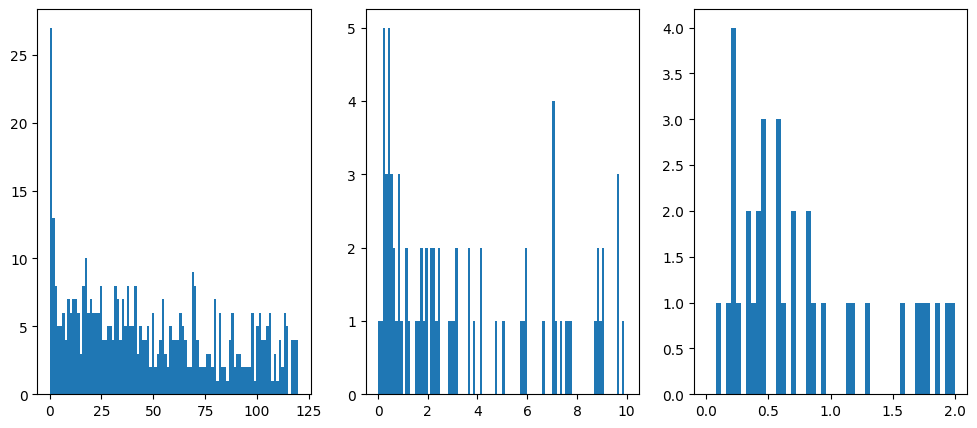

In [123]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.hist(u.Quantity(csc['seps']).to(u.arcsec), bins=100)
ax2.hist(u.Quantity(csc['seps']).to(u.arcsec), bins=100, range=(0*u.arcsec, 10*u.arcsec));
ax3.hist(u.Quantity(csc['seps']).to(u.arcsec), bins=50, range=(0*u.arcsec, 2*u.arcsec));

Now do a by-eye inspection at https://heasarc.gsfc.nasa.gov/xamin/xamin.jsp - the below prints out coordinates, as well as a blank dictionary which is to be copied into the next cell and filled out.

In [156]:
possible_match_rad = 5*u.arcsec

print('by_eye_checks = {')
for hostid in np.unique(csc[u.Quantity(csc['seps'])<possible_match_rad]['hostid']):
    row = hosts[hosts['HOSTID']==hostid][0]
    print(f"'{hostid}': '',")
    print('# {0.ra.deg:.9},{0.dec.deg:.9}'.format(row['coord']))
print('}')

by_eye_checks = {
'nsa133115': '',
# 45.910458,-15.6138572
'nsa135739': '',
# 138.101577,35.0274969
'nsa138201': '',
# 162.817584,27.9750391
'nsa138375': '',
# 164.006163,57.1169763
'nsa139121': '',
# 169.605291,58.7862361
'nsa140594': '',
# 180.098356,-1.100072
'nsa143555': '',
# 202.547541,46.6708056
'nsa144262': '',
# 210.175128,55.1644509
'nsa147606': '',
# 255.209689,23.0110376
'nsa150578': '',
# 346.236102,12.3228077
'nsa150887': '',
# 348.682763,4.533989
'nsa157300': '',
# 143.025937,8.4418092
'nsa164865': '',
# 215.265411,3.2710116
'nsa165153': '',
# 218.023359,57.9214316
'nsa67650': '',
# 213.89202,36.226669
'nsa94340': '',
# 208.324161,33.4908244
'pgc12131': '',
# 49.0032315,-2.4273468
'pgc12431': '',
# 49.9627635,-26.0605611
'pgc14084': '',
# 58.662132,-20.5023357
'pgc26034': '',
# 138.521169,40.1137263
'pgc27982': '',
# 146.425173,-14.3263754
'pgc42139': '',
# 189.354291,74.1918611
'pgc43426': '',
# 192.530042,72.8744722
'pgc45170': '',
# 196.059813,-10.3395694
'pgc47394': 

The options are:
* 'a' - strong point source at glx center
* 'y' - definitely real source at glx center
* 'm' - possible source, but not obvious
* 'n' - galaxy definitly not x-ray source
* 'f' - not in footprint of heasarc viewer tool

In [175]:
by_eye_checks_csc = {
'nsa133115': 'm',
# 45.910458,-15.6138572
'nsa135739': 'n',
# 138.101577,35.0274969
'nsa138201': 'y',
# 162.817584,27.9750391
'nsa138375': 'f',  # theres a source in the catalog but it's not in the Xamin tool?
# 164.006163,57.1169763
'nsa139121': 'n',
# 169.605291,58.7862361
'nsa140594': 'm', # a lot of null columns, maybe an extended source?
# 180.098356,-1.100072
'nsa143555': 'y',  # borderline weak but something is definitiyl there
# 202.547541,46.6708056
'nsa144262': 'y',  # CSC and optical images off-center?
# 210.175128,55.1644509
'nsa147606': 'y',
# 255.209689,23.0110376
'nsa150578': 'y', #elongated along bar?
# 346.236102,12.3228077
'nsa150887': 'm',
# 348.682763,4.533989
'nsa157300': 'm',
# 143.025937,8.4418092
'nsa164865': 'y',
# 215.265411,3.2710116
'nsa165153': 'n',
# 218.023359,57.9214316
'nsa67650': 'm', #nearly edge-on - extincted?
# 213.89202,36.226669
'nsa94340': 'y',
# 208.324161,33.4908244
'pgc12131': 'm', #confusing - there are quite a few source but not p[oint-like?
# 49.0032315,-2.4273468
'pgc12431': 'n',
# 49.9627635,-26.0605611
'pgc14084': 'm',  #diffuse and maybe off-center, but definitely detection
# 58.662132,-20.5023357
'pgc26034': 'm',  #diffuse and off-center  but real
# 138.521169,40.1137263
'pgc27982': 'a',  # VERY bright point-like source - lookint it up its a well-known seyfert
# 146.425173,-14.3263754
'pgc42139': 'y',
# 189.354291,74.1918611
'pgc43426': 'y',  #point source but not especially bright
# 192.530042,72.8744722
'pgc45170': 'y',  # point-like but seems a bit diffuse?
# 196.059813,-10.3395694
'pgc47394': 'm',  #point-like but not very bright
# 202.453191,-17.9664979
'pgc52521': 'y',
# 220.599537,-17.2530053
'pgc61742': 'n',
# 274.943166,74.5683889
'pgc64980': 'm',  #point but not strong
# 308.585718,-31.9808826
'pgc70094': 'm',  # definite but rather extended emission
# 344.306316,-43.3960258
'pgc70676': 'm',
# 348.031554,-28.539653
'pgc72060': 'n',
# 354.974288,-12.2927807
'pgc8160': 'y',  # a central source but several others near the core as well
# 32.08803,10.9949848
}

In [185]:
hosts['in_csc'] = np.zeros(len(hosts), dtype=bool)
hosts['src_in_csc'] = np.zeros(len(hosts), dtype=bool)
for k,v in by_eye_checks_csc.items():
    hostsmsk = hosts['HOSTID']==k
    if v!='f':
        hosts['in_csc'][hostsmsk] = True
    if v=='a' or v=='y':
        hosts['src_in_csc'][hostsmsk] = True

In [186]:
np.sum(hosts['in_csc'])/len(hosts), np.sum(hosts['src_in_csc'])/np.sum(hosts['in_csc'])

(0.10333333333333333, 0.41935483870967744)

### XMM-Newton

In [158]:
{k:(len(v), tables_dct[k].description) for k,v in xmmn_matches.items() if len(v) > 0}

{'caixa': (1, 'Catalog of AGN in the XMM-Newton Archive'),
 'xmmlss10ks': (5,
  'XMM-Newton Large-Scale Structure Uniform 10-ksec Exposure X-Ray'),
 'xmmlssdeep': (6,
  'XMM-Newton Large-Scale Structure Deep Full-Exposure X-Ray Source'),
 'xmmslewcln': (6, 'XMM-Newton Slew Survey Clean Source Catalog, v2.0'),
 'xmmslewegs': (1, 'XMM-Newton Slew Survey Extragalactic Sample'),
 'xmmslewful': (11, 'XMM-Newton Slew Survey Full Source Catalog, v2.0'),
 'xmmssc': (255,
  'XMM-Newton Serendipitous Source Catalog (4XMM-DR13 Version)'),
 'xmmssclwbd': (7, 'XMM-Newton 2XMMi-DR3 Selected Source Detections Catalog'),
 'xmmssclwbs': (2,
  'XMM-Newton 2XMMi-DR3 Selected Source Classifications Catalog'),
 'xmmstack': (77,
  'XMM-Newton Serendipitous Source Catalog from Stacked Observation'),
 'xmmstackob': (352,
  'XMM-Newton Serendipitous Source Catalog from Stacked Observation')}

In [159]:
xmmn_matches['caixa']

caixa___row,caixa_name,caixa_ra,caixa_dec,caixa_lii,caixa_bii,caixa_obsid,caixa_exposure,caixa_sb_flux,caixa_sb_flux_error,caixa_hb_flux,caixa_hb_flux_error,caixa_sb_lx,caixa_sb_lx_error,caixa_hb_lx,caixa_hb_lx_error,caixa_sb_spect_index,caixa_sb_spect_index_pos_err,caixa_sb_spect_index_neg_err,caixa_hb_spect_index,caixa_hb_spect_index_pos_err,caixa_hb_spect_index_neg_err,caixa_ew_6p4_kev,caixa_ew_6p4_kev_pos_err,caixa_ew_6p4_kev_neg_err,caixa_ew_6p7_kev,caixa_ew_6p7_kev_pos_err,caixa_ew_6p7_kev_neg_err,caixa_ew_6p96_kev,caixa_ew_6p96_kev_pos_err,caixa_ew_6p96_kev_neg_err,caixa_redshift,caixa_abs_mag,caixa_flux_6_cm,caixa_flux_6_cm_flag,caixa_ref_flux_6_cm,caixa_flux_20_cm,caixa_ref_flux_20_cm,caixa_fwhm_h_beta,caixa_ref_fwhm_h_beta,caixa_log_blackhole_mass,caixa_ref_log_blackhole_mass,caixa_log_blackhole_mass_flag,caixa_vmag,caixa_bv_color,caixa___x_ra_dec,caixa___y_ra_dec,caixa___z_ra_dec,hostid
,,deg,deg,deg,deg,,s,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg / s,erg / s,erg / s,erg / s,,,,,,,eV,eV,eV,eV,eV,eV,eV,eV,eV,,mag,mJy,,,mJy,,km / s,,Solar_Mass,,,mag,mag,,,,
int32,object,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16,int16,int16,int16,int16,int16,int16,int16,float64,float64,float64,object,object,float64,object,int32,object,float64,object,object,float64,float64,float64,float64,float64,object
154,NGC 3516,166.69788,72.568580,133.23567,42.40282,0107460701,87400,2.4e-12,5e-14,1.55e-11,9e-14,4.59e+41,1e+40,2.89e+42,2e+40,5.240,0.130,0.080,0.887,0.008,0.008,244,10,10,45,8,8,27,7,10,0.0088,-20.5,15.00,,1,27.0,1,4770,i,7.36,A,r,12.40,0.72,0.0689254145594522,-0.291526840688724,0.954076196320744,pgc33623


that one is NGC 3516 - one of the original Seyfert Seyferts

In [161]:
cat = xmmn_matches['xmmslewful']
cat

xmmslewful___row,xmmslewful_xmmslew_name,xmmslewful_obsid,xmmslewful_sourcenum,xmmslewful_ra,xmmslewful_dec,xmmslewful_radec_error,xmmslewful_lii,xmmslewful_bii,xmmslewful_hr1,xmmslewful_hr1_error,xmmslewful_time,xmmslewful_end_time,xmmslewful_scts_b8,xmmslewful_scts_b8_error,xmmslewful_scts_b7,xmmslewful_scts_b7_error,xmmslewful_scts_b6,xmmslewful_scts_b6_error,xmmslewful_x_ima_b8,xmmslewful_y_ima_b8,xmmslewful_x_ima_b7,xmmslewful_y_ima_b7,xmmslewful_x_ima_b6,xmmslewful_y_ima_b6,xmmslewful_ext_b8,xmmslewful_ext_b8_error,xmmslewful_ext_b7,xmmslewful_ext_b7_error,xmmslewful_ext_b6,xmmslewful_ext_b6_error,xmmslewful_det_ml_b8,xmmslewful_det_ml_b7,xmmslewful_det_ml_b6,xmmslewful_ext_ml_b8,xmmslewful_ext_ml_b7,xmmslewful_ext_ml_b6,xmmslewful_bg_map_b8,xmmslewful_bg_map_b7,xmmslewful_bg_map_b6,xmmslewful_exp_map_b8,xmmslewful_exp_map_b7,xmmslewful_exp_map_b6,xmmslewful_flux_b8,xmmslewful_flux_b8_error,xmmslewful_flux_b7,xmmslewful_flux_b7_error,xmmslewful_flux_b6,xmmslewful_flux_b6_error,xmmslewful_count_rate_b8,xmmslewful_count_rate_b8_error,xmmslewful_count_rate_b7,xmmslewful_count_rate_b7_error,xmmslewful_count_rate_b6,xmmslewful_count_rate_b6_error,xmmslewful_ra_b8,xmmslewful_dec_b8,xmmslewful_radec_b8_error,xmmslewful_lii_b8,xmmslewful_bii_b8,xmmslewful_ra_b7,xmmslewful_dec_b7,xmmslewful_radec_b7_error,xmmslewful_lii_b7,xmmslewful_bii_b7,xmmslewful_ra_b6,xmmslewful_dec_b6,xmmslewful_radec_b6_error,xmmslewful_lii_b6,xmmslewful_bii_b6,xmmslewful_val_flag,xmmslewful_srcname_b8,xmmslewful_srcname_b7,xmmslewful_srcname_b6,xmmslewful_ximname_b8,xmmslewful_ximname_b7,xmmslewful_ximname_b6,xmmslewful_ver_inext,xmmslewful_ver_halo,xmmslewful_ver_hibgnd,xmmslewful_ver_nredg,xmmslewful_ver_psusp,xmmslewful_ver_false,xmmslewful_flag_comment,xmmslewful_name,xmmslewful_alt_name,xmmslewful_rass_name,xmmslewful_id_category,xmmslewful_id_resource,xmmslewful_id_offset,xmmslewful_rass_offset,xmmslewful_mode_id,xmmslewful_image_bg_rate,xmmslewful_subimage_time,xmmslewful_subimage_end_time,xmmslewful_ver_optload,xmmslewful_filtered_counts,xmmslewful_unfiltered_counts,xmmslewful_xmmsl1_name,xmmslewful_extras_source_number,xmmslewful_class,xmmslewful___x_ra_dec,xmmslewful___y_ra_dec,xmmslewful___z_ra_dec,hostid
,,,,deg,deg,arcsec,deg,deg,,,d,d,ct,ct,ct,ct,ct,ct,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,,,,,,,ct / pix,ct / pix,ct / pix,s,s,s,erg/cm^2/s,erg/cm^2/s,erg/cm^2/s,erg/cm^2/s,erg/cm^2/s,erg/cm^2/s,ct / s,ct / s,ct / s,ct / s,ct / s,ct / s,deg,deg,arcsec,deg,deg,deg,deg,arcsec,deg,deg,deg,deg,arcsec,deg,deg,,,,,,,,,,,,,,,,,,,,arcsec,arcsec,,ct / s,d,d,,ct,ct,,,,,,,
int32,object,object,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object,float64,float64,float64,object,int16,int16,object,int32,int16,float64,float64,float64,object
71505,XMMSL2 J091356.8+791120,9206600002,31,138.486974,79.188860,3.17264,133.41008,33.03379,--,--,55641.6074074074,55641.6074074074,14.152,3.85107,--,--,13.287,3.69552,1002.3,397.04,--,--,1001.9,397.25,0,0,--,--,0,0,53.062,--,60.765,--,--,--,0.00084878,--,0.00029853,5.4767,--,6.3242,8.1628e-12,2.2213e-12,--,--,3.017e-12,8.3912e-13,2.584,0.70318,--,--,2.101,0.58435,138.4848,79.1886,3.347,133.4106,33.03357,--,--,--,--,--,138.487,79.18886,3.1726,133.4101,33.03379,CLEAN_SAMPLE,xs2066_9206600002_09:13:56.3+79:11:19,,xs2066_9206600002_09:13:56.8+79:11:20,P9206600002PNS003IMAGE_8022.FTZ,,P920660

In [168]:
cat = xmmn_matches['xmmslewful']
cat_coo = SkyCoord(ra=cat['xmmslewful_ra'], dec=cat['xmmslewful_dec'])

seps = []
for coo, row in zip(cat_coo,cat):
    hrow = hosts[row['hostid']==hosts['HOSTID']]
    assert len(hrow)==1, len(hrow)
    hrow = hrow[0]

    seps.append(hrow['coord'].separation(coo))
cat['seps'] = u.Quantity(seps)
cat['cp-coo'] = ['{0.ra.deg:.9},{0.dec.deg:.9}'.format(coo) for coo in cat_coo]
cat

xmmslewful___row,xmmslewful_xmmslew_name,xmmslewful_obsid,xmmslewful_sourcenum,xmmslewful_ra,xmmslewful_dec,xmmslewful_radec_error,xmmslewful_lii,xmmslewful_bii,xmmslewful_hr1,xmmslewful_hr1_error,xmmslewful_time,xmmslewful_end_time,xmmslewful_scts_b8,xmmslewful_scts_b8_error,xmmslewful_scts_b7,xmmslewful_scts_b7_error,xmmslewful_scts_b6,xmmslewful_scts_b6_error,xmmslewful_x_ima_b8,xmmslewful_y_ima_b8,xmmslewful_x_ima_b7,xmmslewful_y_ima_b7,xmmslewful_x_ima_b6,xmmslewful_y_ima_b6,xmmslewful_ext_b8,xmmslewful_ext_b8_error,xmmslewful_ext_b7,xmmslewful_ext_b7_error,xmmslewful_ext_b6,xmmslewful_ext_b6_error,xmmslewful_det_ml_b8,xmmslewful_det_ml_b7,xmmslewful_det_ml_b6,xmmslewful_ext_ml_b8,xmmslewful_ext_ml_b7,xmmslewful_ext_ml_b6,xmmslewful_bg_map_b8,xmmslewful_bg_map_b7,xmmslewful_bg_map_b6,xmmslewful_exp_map_b8,xmmslewful_exp_map_b7,xmmslewful_exp_map_b6,xmmslewful_flux_b8,xmmslewful_flux_b8_error,xmmslewful_flux_b7,xmmslewful_flux_b7_error,xmmslewful_flux_b6,xmmslewful_flux_b6_error,xmmslewful_count_rate_b8,xmmslewful_count_rate_b8_error,xmmslewful_count_rate_b7,xmmslewful_count_rate_b7_error,xmmslewful_count_rate_b6,xmmslewful_count_rate_b6_error,xmmslewful_ra_b8,xmmslewful_dec_b8,xmmslewful_radec_b8_error,xmmslewful_lii_b8,xmmslewful_bii_b8,xmmslewful_ra_b7,xmmslewful_dec_b7,xmmslewful_radec_b7_error,xmmslewful_lii_b7,xmmslewful_bii_b7,xmmslewful_ra_b6,xmmslewful_dec_b6,xmmslewful_radec_b6_error,xmmslewful_lii_b6,xmmslewful_bii_b6,xmmslewful_val_flag,xmmslewful_srcname_b8,xmmslewful_srcname_b7,xmmslewful_srcname_b6,xmmslewful_ximname_b8,xmmslewful_ximname_b7,xmmslewful_ximname_b6,xmmslewful_ver_inext,xmmslewful_ver_halo,xmmslewful_ver_hibgnd,xmmslewful_ver_nredg,xmmslewful_ver_psusp,xmmslewful_ver_false,xmmslewful_flag_comment,xmmslewful_name,xmmslewful_alt_name,xmmslewful_rass_name,xmmslewful_id_category,xmmslewful_id_resource,xmmslewful_id_offset,xmmslewful_rass_offset,xmmslewful_mode_id,xmmslewful_image_bg_rate,xmmslewful_subimage_time,xmmslewful_subimage_end_time,xmmslewful_ver_optload,xmmslewful_filtered_counts,xmmslewful_unfiltered_counts,xmmslewful_xmmsl1_name,xmmslewful_extras_source_number,xmmslewful_class,xmmslewful___x_ra_dec,xmmslewful___y_ra_dec,xmmslewful___z_ra_dec,hostid,seps,cp-coo
,,,,deg,deg,arcsec,deg,deg,,,d,d,ct,ct,ct,ct,ct,ct,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,,,,,,,ct / pix,ct / pix,ct / pix,s,s,s,erg/cm^2/s,erg/cm^2/s,erg/cm^2/s,erg/cm^2/s,erg/cm^2/s,erg/cm^2/s,ct / s,ct / s,ct / s,ct / s,ct / s,ct / s,deg,deg,arcsec,deg,deg,deg,deg,arcsec,deg,deg,deg,deg,arcsec,deg,deg,,,,,,,,,,,,,,,,,,,,arcsec,arcsec,,ct / s,d,d,,ct,ct,,,,,,,,deg,
int32,object,object,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object,float64,float64,float64,object,int16,int16,object,int32,int16,float64,float64,float64,object,float64,str22
71505,XMMSL2 J091356.8+791120,9206600002,31,138.486974,79.188860,3.17264,133.41008,33.03379,--,--,55641.6074074074,55641.6074074074,14.152,3.85107,--,--,13.287,3.69552,1002.3,397.04,--,--,1001.9,397.25,0,0,--,--,0,0,53.062,--,60.765,--,--,--,0.00084878,--,0.00029853,5.4767,--,6.3242,8.1628e-12,2.2213e-12,--,--,3.017e-12,8.3912e-13,2.584,0.70318,--,--,2.101,0.58435,138.4848,79.1886,3.347,133.4106,33.03357,--,--,--,--,--,138.487,79.18886,3.1726,133.4101,33.03379,CLEAN_SAMPLE,xs2066_9206600002_09:13:56.3+79:11:19,,xs2066_9206600002_09:13:56.8+79:11:20,P92066000

In [169]:
xmmslewful_comments = {
    'pgc25999': 'Nothing there? But visible in ROSAT',
    'pgc27982': 'Seyfert',
    'nsa142509': 'Nothing, including ROSAT',
    'nsa163956': 'In ROSAT',
    'pgc51055': 'Nothing, including ROSAT',
    'pgc67663': 'Nothing, including ROSAT',
    'pgc70505': 'Nothing, including ROSAT',
}

In [171]:
cat = xmmn_matches['xmmssc']
cat_coo = SkyCoord(ra=cat['xmmssc_ra'], dec=cat['xmmssc_dec'])

seps = []
for coo, row in zip(cat_coo,cat):
    hrow = hosts[row['hostid']==hosts['HOSTID']]
    assert len(hrow)==1, len(hrow)
    hrow = hrow[0]

    seps.append(hrow['coord'].separation(coo))
cat['seps'] = u.Quantity(seps)
cat['cp-coo'] = ['{0.ra.deg:.9},{0.dec.deg:.9}'.format(coo) for coo in cat_coo]

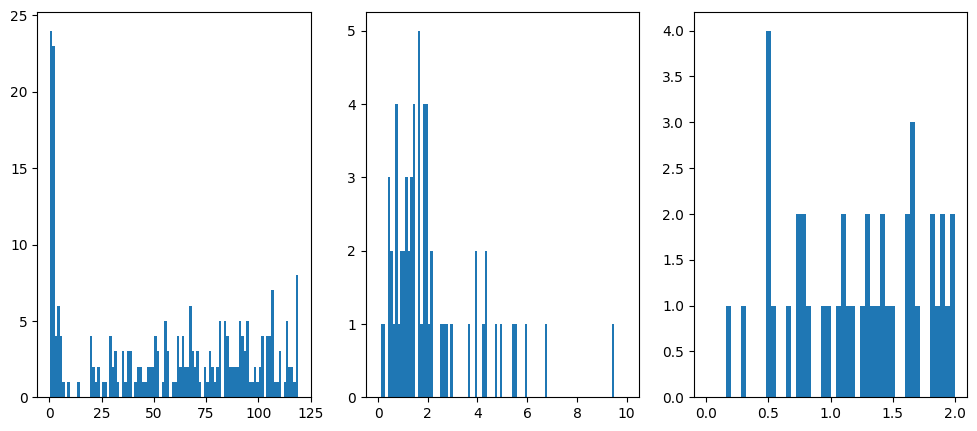

In [173]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.hist(u.Quantity(cat['seps']).to(u.arcsec), bins=100)
ax2.hist(u.Quantity(cat['seps']).to(u.arcsec), bins=100, range=(0*u.arcsec, 10*u.arcsec));
ax3.hist(u.Quantity(cat['seps']).to(u.arcsec), bins=50, range=(0*u.arcsec, 2*u.arcsec));

In [174]:
possible_match_rad = 4*u.arcsec

print('by_eye_checks = {')
for hostid in np.unique(cat[u.Quantity(cat['seps'])<possible_match_rad]['hostid']):
    row = hosts[hosts['HOSTID']==hostid][0]
    print(f"'{hostid}': '',")
    print('# {0.ra.deg:.9},{0.dec.deg:.9}'.format(row['coord']))
print('}')

by_eye_checks = {
'nsa133115': '',
# 45.910458,-15.6138572
'nsa133141': '',
# 46.5125295,-15.6112493
'nsa133953': '',
# 72.136854,-6.5700972
'nsa136403': '',
# 150.358014,15.7699934
'nsa13927': '',
# 180.676083,1.9768187
'nsa140458': '',
# 178.988949,6.7495342
'nsa141315': '',
# 186.325234,4.9249453
'nsa145729': '',
# 224.594497,-1.0910342
'nsa150578': '',
# 346.236102,12.3228077
'nsa155005': '',
# 35.401959,-5.5213909
'nsa164865': '',
# 215.265411,3.2710116
'pgc12131': '',
# 49.0032315,-2.4273468
'pgc14084': '',
# 58.662132,-20.5023357
'pgc27982': '',
# 146.425173,-14.3263754
'pgc28876': '',
# 149.873013,-22.8263321
'pgc33623': '',
# 166.69779,72.5685398
'pgc35869': '',
# 173.988792,70.5356348
'pgc43642': '',
# 193.055234,-29.840649
'pgc45170': '',
# 196.059813,-10.3395694
'pgc46441': '',
# 199.835985,-14.8446124
'pgc47394': '',
# 202.453191,-17.9664979
'pgc63571': '',
# 295.8935,-58.6557222
'pgc63620': '',
# 296.313231,-54.3441973
'pgc64446': '',
# 304.575647,-44.8070492
'pgc66318': 

The options are:
* 'a' - strong point source at glx center
* 'y' - definitely real source at glx center
* 'm' - possible source, but not obvious
* 'n' - galaxy definitly not x-ray source
* 'f' - not in footprint of heasarc viewer tool

In [176]:
by_eye_checks_xmmssc = {
'nsa133115': 'f',
# 45.910458,-15.6138572
'nsa133141': 'y',
# 46.5125295,-15.6112493
'nsa133953': 'm',
# 72.136854,-6.5700972
'nsa136403': 'y',
# 150.358014,15.7699934
'nsa13927': 'f',
# 180.676083,1.9768187
'nsa140458': 'y',
# 178.988949,6.7495342
'nsa141315': 'y',  # catalog source is off-center but it's a real source
# 186.325234,4.9249453
'nsa145729': 'n',
# 224.594497,-1.0910342
'nsa150578': 'm',  # there are some strong source in the spiral arms but not in the core
# 346.236102,12.3228077
'nsa155005': 'n',
# 35.401959,-5.5213909
'nsa164865': 'm',  # weak source but maybe point-like
# 215.265411,3.2710116
'pgc12131': 'y',  # quite strong point source... POSSIBLE AGN?
# 49.0032315,-2.4273468
'pgc14084': 'm',  # strong but maybe a bit extened?
# 58.662132,-20.5023357
'pgc27982': 'a',  # NGC 2992, famous Seyfert
# 146.425173,-14.3263754
'pgc28876': 'f',
# 149.873013,-22.8263321
'pgc33623': 'a',  # NGC 3516, Seyfert Seyfert
# 166.69779,72.5685398
'pgc35869': 'm',  # artifacts
# 173.988792,70.5356348
'pgc43642': 'm',  # very weak source
# 193.055234,-29.840649
'pgc45170': 'm',  # extended emission from bar, but point-like in swift?  faint though
# 196.059813,-10.3395694
'pgc46441': 'y',  # weak but point-like at center
# 199.835985,-14.8446124
'pgc47394': 'm',  # extended?
# 202.453191,-17.9664979
'pgc63571': 'y',  # a bit of a mess but quite strong
# 295.8935,-58.6557222
'pgc63620': 'y',  # weak but point-like
# 296.313231,-54.3441973
'pgc64446': 'y',  #point-like, possible AGN?
# 304.575647,-44.8070492
'pgc66318': 'm',  # weak, possibly extended
# 317.967001,-49.2837654
'pgc67146': 'm',  # fair amouint of extended
# 325.053719,-42.5394068
'pgc67892': 'm',  # weak, extended
# 330.590094,-18.9165097
'pgc70094': 'y',
# 344.306316,-43.3960258
'pgc70676': 'y',  #possible binary nucleus?  Or Xray binary in corner?  Oh, although not as promising in Chandra
# 348.031554,-28.539653
'pgc72060': 'm',  # weak and a bit extended
# 354.974288,-12.2927807
}

In [187]:
hosts['in_xmmssc'] = np.zeros(len(hosts), dtype=bool)
hosts['src_in_xmmssc'] = np.zeros(len(hosts), dtype=bool)
for k,v in by_eye_checks_xmmssc.items():
    hostsmsk = hosts['HOSTID']==k
    if v!='f':
        hosts['in_xmmssc'][hostsmsk] = True
    if v=='a' or v=='y':
        hosts['src_in_xmmssc'][hostsmsk] = True

In [188]:
np.sum(hosts['in_xmmssc'])/len(hosts), np.sum(hosts['src_in_xmmssc'])/np.sum(hosts['in_xmmssc'])

(0.09, 0.48148148148148145)

# Summary fractions

In [189]:
np.sum(hosts['in_xmmssc']|hosts['in_csc'])/len(hosts), np.sum(hosts['src_in_xmmssc']|hosts['src_in_csc'])/np.sum(hosts['in_xmmssc']|hosts['in_csc'])

(0.16, 0.5208333333333334)

In [190]:
np.sum(hosts['src_in_xmmssc']|hosts['src_in_csc'])

25